In [1]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import six
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import round

In [2]:
#Inicializamos la sesion de Spark
spark = SparkSession \
    .builder \
    .config('spark.sql.debug.maxToStringFields', 2000) \
    .getOrCreate()

In [3]:
#Lectura del archivo .parquet
df = spark.read.parquet('/LUSTRE/home/mcd-01/dataset.parquet')

### Exploración de Datos

Schema de nuestro conjunto de datos

In [4]:
df.cache()
df.printSchema()

root
 |-- XLAT: double (nullable = true)
 |-- XLONG: double (nullable = true)
 |-- LU_INDEX: double (nullable = true)
 |-- VAR_SSO: double (nullable = true)
 |-- MU: double (nullable = true)
 |-- MUB: double (nullable = true)
 |-- Q2: double (nullable = true)
 |-- T2: double (nullable = true)
 |-- TH2: double (nullable = true)
 |-- PSFC: double (nullable = true)
 |-- U10: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- TOPOSLPX: double (nullable = true)
 |-- TOPOSLPY: double (nullable = true)
 |-- SHDMAX: double (nullable = true)
 |-- SHDMIN: double (nullable = true)
 |-- SNOALB: double (nullable = true)
 |-- SEAICE: double (nullable = true)
 |-- IVGTYP: double (nullable = true)
 |-- ISLTYP: double (nullable = true)
 |-- VEGFRA: double (nullable = true)
 |-- SNOW: double (nullable = true)
 |-- SNOWH: double (nullable = true)
 |-- CANWAT: double (nullable = true)
 |-- LAKE_DEPTH: double (nullable = true)
 |-- UOCE: double (nullable = true)
 |-- VOCE: double (nullable = 

Análisis exploratorio

In [5]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
XLAT,106218,24.034976501572274,8.670468176868019,8.225723,39.51725
XLONG,106218,-101.34100341677491,12.977148743656334,-126.501343,-76.180664
LU_INDEX,106218,13.106215519026907,5.140676772032897,1.0,17.0
VAR_SSO,106218,401.9849938938036,1283.3207106221182,0.0,23457.728516
MU,106218,1810.8443963735126,781.9099183325786,569.960938,3451.492188
MUB,106218,91341.62153163127,6807.606878952749,59051.03125,96245.40625
Q2,106218,0.009804539654295888,0.00549232365592487,0.001053,0.018167
T2,106218,290.7366843312529,8.757078003168958,257.428162,304.739929
TH2,106218,292.5197530702803,7.940100425765985,267.574188,318.953613


Correlación entre variables independientes y la variable objetivo

In [6]:
for idx in df.columns:
    if not(isinstance(df.select(idx).take(1)[0][0], six.string_types)):
        print("Correlacion de TEMP con ", idx, df.stat.corr("TEMP", idx))

Correlacion de TEMP con  XLAT -0.8554067350291159
Correlacion de TEMP con  XLONG -0.04856813258340898
Correlacion de TEMP con  LU_INDEX 0.597937347779718
Correlacion de TEMP con  VAR_SSO -0.17860378937102464
Correlacion de TEMP con  MU -0.8458409364115996
Correlacion de TEMP con  MUB 0.5531859457122403
Correlacion de TEMP con  Q2 0.9098693143727444
Correlacion de TEMP con  T2 0.9994532276521065
Correlacion de TEMP con  TH2 0.7393555246437803
Correlacion de TEMP con  PSFC 0.4825029908000767
Correlacion de TEMP con  U10 -0.3707340856962934
Correlacion de TEMP con  V10 -0.1813136838704939
Correlacion de TEMP con  TOPOSLPX nan
Correlacion de TEMP con  TOPOSLPY nan
Correlacion de TEMP con  SHDMAX -0.5899623402347254
Correlacion de TEMP con  SHDMIN -0.4599172446373808
Correlacion de TEMP con  SNOALB -0.6667962821697532
Correlacion de TEMP con  SEAICE nan
Correlacion de TEMP con  IVGTYP 0.5979373477797182
Correlacion de TEMP con  ISLTYP 0.720751159836306
Correlacion de TEMP con  VEGFRA -0.443

In [7]:
#Utilizamos la transformacion "VectorAssembler para transformar multiples columnas en un columna de vectores necesario.
#para la utilización de la libreria Spark ml
vectorAssembler = VectorAssembler(inputCols = df.drop("TEMP").columns, outputCol = "FEATURES")
vdf = vectorAssembler.transform(df)
vdf = vdf.select(["FEATURES","TEMP"])
vdf.show(5)

+--------------------+-----+
|            FEATURES| TEMP|
+--------------------+-----+
|[35.946552,-100.6...|279.0|
|[35.945969,-100.4...|280.0|
|[35.945255,-100.3...|280.0|
|[35.944454,-100.2...|280.0|
|[35.943546,-100.1...|280.0|
+--------------------+-----+
only showing top 5 rows



Grafica de la temperatura original

In [8]:
x_aux = range(0, vdf.count())
y_aux = vdf.select("TEMP").collect()  

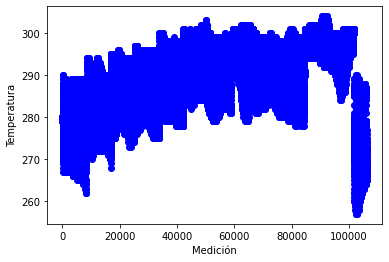

In [9]:
plt.scatter(x_aux, y_aux, color='blue')
plt.xlabel("Medición")
plt.ylabel("Temperatura")
plt.show()

### Preparación de los datos para el entrenamiento.

Estandarización/Normalización de los datos

In [10]:
#Utilizamos StandarScaler para transformar los datos de manera que su distribución 
#tenga un valor medio 0 y una desviación estándar de 1 para luegro agregarlos a una nueva columna.
sscaler = StandardScaler(withMean = True, withStd = True,
                         inputCol = "FEATURES", 
                         outputCol = "STD_FEATURES")

model = sscaler.fit(vdf)
vdf = model.transform(vdf)
vdf.show(5)

+--------------------+-----+--------------------+
|            FEATURES| TEMP|        STD_FEATURES|
+--------------------+-----+--------------------+
|[35.946552,-100.6...|279.0|[1.37380995529246...|
|[35.945969,-100.4...|280.0|[1.37374271555544...|
|[35.945255,-100.3...|280.0|[1.37366036706106...|
|[35.944454,-100.2...|280.0|[1.37356798450643...|
|[35.943546,-100.1...|280.0|[1.37346326121104...|
+--------------------+-----+--------------------+
only showing top 5 rows



Dividimos nos datos en 70% de entrenamiento y 30 % de prueba

In [11]:
splits = vdf.randomSplit([0.7, 0.3])
train_data = splits[0]
test_data = splits[1]

In [12]:
train_data.describe().show()

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|            74219|
|   mean|290.2323394279093|
| stddev| 8.75019857406846|
|    min|            257.0|
|    max|            304.0|
+-------+-----------------+



In [13]:
test_data.describe().show()

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|            31999|
|   mean|290.2354761086284|
| stddev|8.771057786890019|
|    min|            258.0|
|    max|            304.0|
+-------+-----------------+



### Regresión Lineal 1: Entrenando con datos sin normalizar

In [14]:
regressor1 = LinearRegression(featuresCol = 'FEATURES', labelCol = 'TEMP')

#Learn to fit the model from training set
regressor1 = regressor1.fit(train_data)

#To predict the prices on testing set
pred1 = regressor1.evaluate(test_data)

#Predict the model
pred1.predictions.show()

22/05/17 14:41:27 WARN Instrumentation: [568ea989] regParam is zero, which might cause numerical instability and overfitting.
22/05/17 14:41:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/17 14:41:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/05/17 14:41:29 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/05/17 14:41:29 WARN Instrumentation: [568ea989] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
/storage/apps/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+-----+--------------------+------------------+
|            FEATURES| TEMP|        STD_FEATURES|        prediction|
+--------------------+-----+--------------------+------------------+
|(50,[0,1,2,3,4,5,...|279.0|[1.21209977178234...|279.36160992695415|
|(50,[0,1,2,3,4,5,...|281.0|[1.22978451462115...|280.65314326911374|
|(50,[0,1,2,3,4,5,...|288.0|[1.33670157850856...|  287.880057234972|
|(50,[0,1,2,3,4,5,...|288.0|[1.38144160777652...|287.77548001917995|
|(50,[0,1,2,3,4,5,...|289.0|[1.48617816657306...| 288.9079876771428|
|(50,[0,1,2,4,5,6,...|283.0|[1.17374105882525...| 282.7105716979617|
|(50,[0,1,2,4,5,6,...|284.0|[1.19359396601419...| 283.5486279638823|
|(50,[0,1,2,4,5,6,...|289.0|[1.25721590530828...|  288.940077396813|
|(50,[0,1,2,4,5,6,...|288.0|[1.26586734124805...| 287.8902686219092|
|(50,[0,1,2,4,5,6,...|287.0|[1.29866626215969...|287.33891713415085|
|(50,[0,1,2,4,5,6,...|287.0|[1.30898427477159...|286.94311682890185|
|(50,[0,1,2,4,5,6,...|287.0|[1.321

In [15]:
#coefficient of the regression model
coeff1 = regressor1.coefficients
#X and Y intercept
intr1 = regressor1.intercept
print ("The coefficient of the model is:% a"% coeff1)
print ("The intercept of the model is:% f"% intr1)

The coefficient of the model is:DenseVector([0.0062, -0.0003, -0.0019, -0.0, 0.0002, -0.0001, 12.0426, 0.6653, 0.3258, -0.0, -0.0022, -0.0025, 0.0, 0.0, -0.0024, -0.0026, 0.0771, 0.0, -0.0019, -0.0004, 0.0049, 0.0002, 0.0459, 0.0, -0.005, 0.0, 0.0, 0.0, -0.0079, -0.0, 0.5502, 0.5502, 0.5502, -5.5277, 9707.1965, -0.0117, -0.4236, -0.0042, -0.0043, 0.0062, 0.0937, 0.0125, 0.0411, 0.0952, 0.0, 0.0, 0.0, -0.0411, 0.0517, -0.0043])
The intercept of the model is: 7.281562


In [16]:
eval = RegressionEvaluator(labelCol="TEMP", predictionCol="prediction", metricName="rmse")
# Root Mean Square Error
rmse = eval.evaluate(pred1.predictions)
print("RMSE: %.3f" % rmse)
# Mean Square Error
mse = eval.evaluate(pred1.predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)
# r2 - coefficient of determination
r2 = eval.evaluate(pred1.predictions, {eval.metricName: "r2"})
print("r^2: %.3f" %r2)

RMSE: 0.291
MSE: 0.085
r^2: 0.999


 RMSE Mide las diferencias entre los valores predichos por el modelo y los valores reales.
 
 MSE  Mide el error cuadrado promedio, entre las prediccion del modelo y valor real.
 
 r^2 Indica el porcentaje de variabilidad que puesde ser explicado por nuestro modelo

##### Graficando los resultados

In [17]:
pred1.predictions.show()

+--------------------+-----+--------------------+------------------+
|            FEATURES| TEMP|        STD_FEATURES|        prediction|
+--------------------+-----+--------------------+------------------+
|(50,[0,1,2,3,4,5,...|279.0|[1.21209977178234...|279.36160992695415|
|(50,[0,1,2,3,4,5,...|281.0|[1.22978451462115...|280.65314326911374|
|(50,[0,1,2,3,4,5,...|288.0|[1.33670157850856...|  287.880057234972|
|(50,[0,1,2,3,4,5,...|288.0|[1.38144160777652...|287.77548001917995|
|(50,[0,1,2,3,4,5,...|289.0|[1.48617816657306...| 288.9079876771428|
|(50,[0,1,2,4,5,6,...|283.0|[1.17374105882525...| 282.7105716979617|
|(50,[0,1,2,4,5,6,...|284.0|[1.19359396601419...| 283.5486279638823|
|(50,[0,1,2,4,5,6,...|289.0|[1.25721590530828...|  288.940077396813|
|(50,[0,1,2,4,5,6,...|288.0|[1.26586734124805...| 287.8902686219092|
|(50,[0,1,2,4,5,6,...|287.0|[1.29866626215969...|287.33891713415085|
|(50,[0,1,2,4,5,6,...|287.0|[1.30898427477159...|286.94311682890185|
|(50,[0,1,2,4,5,6,...|287.0|[1.321

In [18]:
vdf1 = pred1.predictions

In [19]:
x_ax1 = range(0, vdf1.count())
y_pred1 = vdf1.select("prediction").collect()
y_orig1 = vdf1.select("TEMP").collect()  

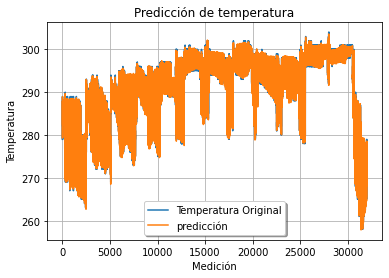

In [20]:
plt.plot(x_ax1, y_orig1, label="Temperatura Original")
plt.plot(x_ax1, y_pred1, label="predicción")
plt.title("Predicción de temperatura")
plt.xlabel('Medición')
plt.ylabel('Temperatura')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

### Regresion Lineal 2:  Entrenando con datos normalizados

In [21]:
lr = LinearRegression(featuresCol="STD_FEATURES", labelCol="TEMP", maxIter=1000, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)

print("Coeficientes: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

pred2 = lr_model.evaluate(test_data)

Coeficientes: [0.0,0.0,0.0,0.0,-0.040820284363067304,0.0,0.059778796326801505,7.243089483351203,0.015182754013591683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5696180439083032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5696180439083094]
Intercept: 290.2329356427421


In [22]:
pred2.predictions.show()

+--------------------+-----+--------------------+------------------+
|            FEATURES| TEMP|        STD_FEATURES|        prediction|
+--------------------+-----+--------------------+------------------+
|(50,[0,1,2,3,4,5,...|279.0|[1.21209977178234...|281.15136186592224|
|(50,[0,1,2,3,4,5,...|281.0|[1.22978451462115...| 282.2644110050941|
|(50,[0,1,2,3,4,5,...|288.0|[1.33670157850856...|287.71430523929894|
|(50,[0,1,2,3,4,5,...|288.0|[1.38144160777652...| 287.6169149100775|
|(50,[0,1,2,3,4,5,...|289.0|[1.48617816657306...| 288.5410562956884|
|(50,[0,1,2,4,5,6,...|283.0|[1.17374105882525...| 284.0728643669161|
|(50,[0,1,2,4,5,6,...|284.0|[1.19359396601419...|284.73038287263006|
|(50,[0,1,2,4,5,6,...|289.0|[1.25721590530828...| 288.6267440071085|
|(50,[0,1,2,4,5,6,...|288.0|[1.26586734124805...|287.74319579678973|
|(50,[0,1,2,4,5,6,...|287.0|[1.29866626215969...|287.25378589182014|
|(50,[0,1,2,4,5,6,...|287.0|[1.30898427477159...| 286.9174977520873|
|(50,[0,1,2,4,5,6,...|287.0|[1.321

In [23]:
vdf2 = pred2.predictions

In [24]:
x_ax2 = range(0, vdf2.count())
#x_ax_list = list(x_ax_0)
y_pred2 = vdf2.select("prediction").collect()
y_orig2 = vdf2.select("TEMP").collect()  

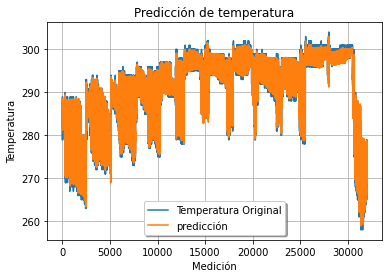

In [25]:
plt.plot(x_ax2, y_orig2, label="Temperatura Original")
plt.plot(x_ax2, y_pred2, label="predicción")
plt.title("Predicción de temperatura")
plt.xlabel('Medición')
plt.ylabel('Temperatura')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [26]:
eval = RegressionEvaluator(labelCol="TEMP", predictionCol="prediction", metricName="rmse")
# Root Mean Square Error
rmse = eval.evaluate(pred2.predictions)
print("RMSE: %.3f" % rmse)
# Mean Square Error
mse = eval.evaluate(pred2.predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)
# r2 - coefficient of determination
r2 = eval.evaluate(pred2.predictions, {eval.metricName: "r2"})
print("r^2: %.3f" %r2)

RMSE: 0.462
MSE: 0.214
r^2: 0.997


### Regresión con Árboles de Decisión - Gradient-boosting

In [27]:
gbm = GBTRegressor(featuresCol = "FEATURES", labelCol = "TEMP", maxIter = 100) #Listo
gbm_model = gbm.fit(train_data)                                                #Listo 
gbt_predictions = gbm_model.transform(test_data)                               #Listo

In [28]:
gbt_evaluator = RegressionEvaluator(labelCol="TEMP", predictionCol="prediction", metricName="rmse")

rmse = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: 'rmse'})
mae = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: 'mae'})
r2 = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: 'r2'})

print("RMSE = ", rmse)
print("MAE = ", mae)
print("R2 = ", r2)

RMSE =  0.3555814540235101
MAE =  0.24952367676508797
R2 =  0.9983564314183743


In [29]:
vdf3=gbt_predictions

In [30]:
x_ax3 = range(0, vdf3.count())
#x_ax_list = list(x_ax_0)
y_pred3 = vdf3.select("prediction").collect()
y_orig3 = vdf3.select("TEMP").collect()  

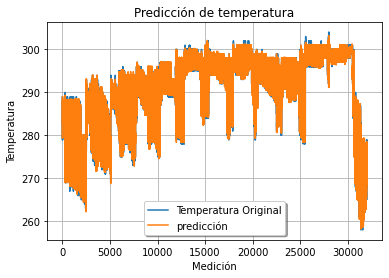

In [31]:
plt.plot(x_ax3, y_orig3, label="Temperatura Original")
plt.plot(x_ax3, y_pred3, label="predicción")
plt.title("Predicción de temperatura")
plt.xlabel('Medición')
plt.ylabel('Temperatura')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

### Evaluar con otro conjunto de datos